In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [ ]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams["text.usetex"] = (
    False  # Plotting the global model is much much faster with tex fonts turned off
)

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
# Western North America example
command_file_name = "../data/command/western_north_america_command.json"

In [4]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(
    assembly, station, sar
)  # Not sure this works correctly

INFO: Read: ../data/command/western_north_america_command.json - celeri.celeri:get_logger:7838 - 2025-05-11 23:20:24
INFO: RUN_NAME: 0000001066 - celeri.celeri:get_logger:7839 - 2025-05-11 23:20:24
INFO: Write log file: ../runs/0000001066/0000001066.log - celeri.celeri:get_logger:7840 - 2025-05-11 23:20:24
INFO: Reading data files - celeri.celeri:read_data:441 - 2025-05-11 23:20:24
SUCCESS: Read: ../data/segment/western_north_america_segment_cascdip.csv - celeri.celeri:read_data:445 - 2025-05-11 23:20:24
SUCCESS: Read: ../data/block/western_north_america_block.csv - celeri.celeri:read_data:450 - 2025-05-11 23:20:24
SUCCESS: Read: ../data/mesh/western_north_america_mesh_parameters.json - celeri.celeri:read_data:457 - 2025-05-11 23:20:24

SUCCESS: Read: ../data/mesh/cascadia.msh - celeri.celeri:read_mesh:436 - 2025-05-11 23:20:24
SUCCESS: Read: ../data/station/western_north_america_station.csv - celeri.celeri:read_data:525 - 2025-05-11 23:20:24
INFO: No mogi_file_name - celeri.celeri:rea

# Get elastic operators and TDE smoothing operators

In [5]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

INFO: Using precomputed elastic operators - celeri.celeri:get_elastic_operators:2007 - 2025-05-11 23:20:25


# Calculate non-elastic operators

In [6]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

INFO: Found 1 slip rate constraints - celeri.celeri:get_slip_rate_constraints:3271 - 2025-05-11 23:20:25
INFO: Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr) - celeri.celeri:get_slip_rate_constraints:3274 - 2025-05-11 23:20:25


# Plot input data

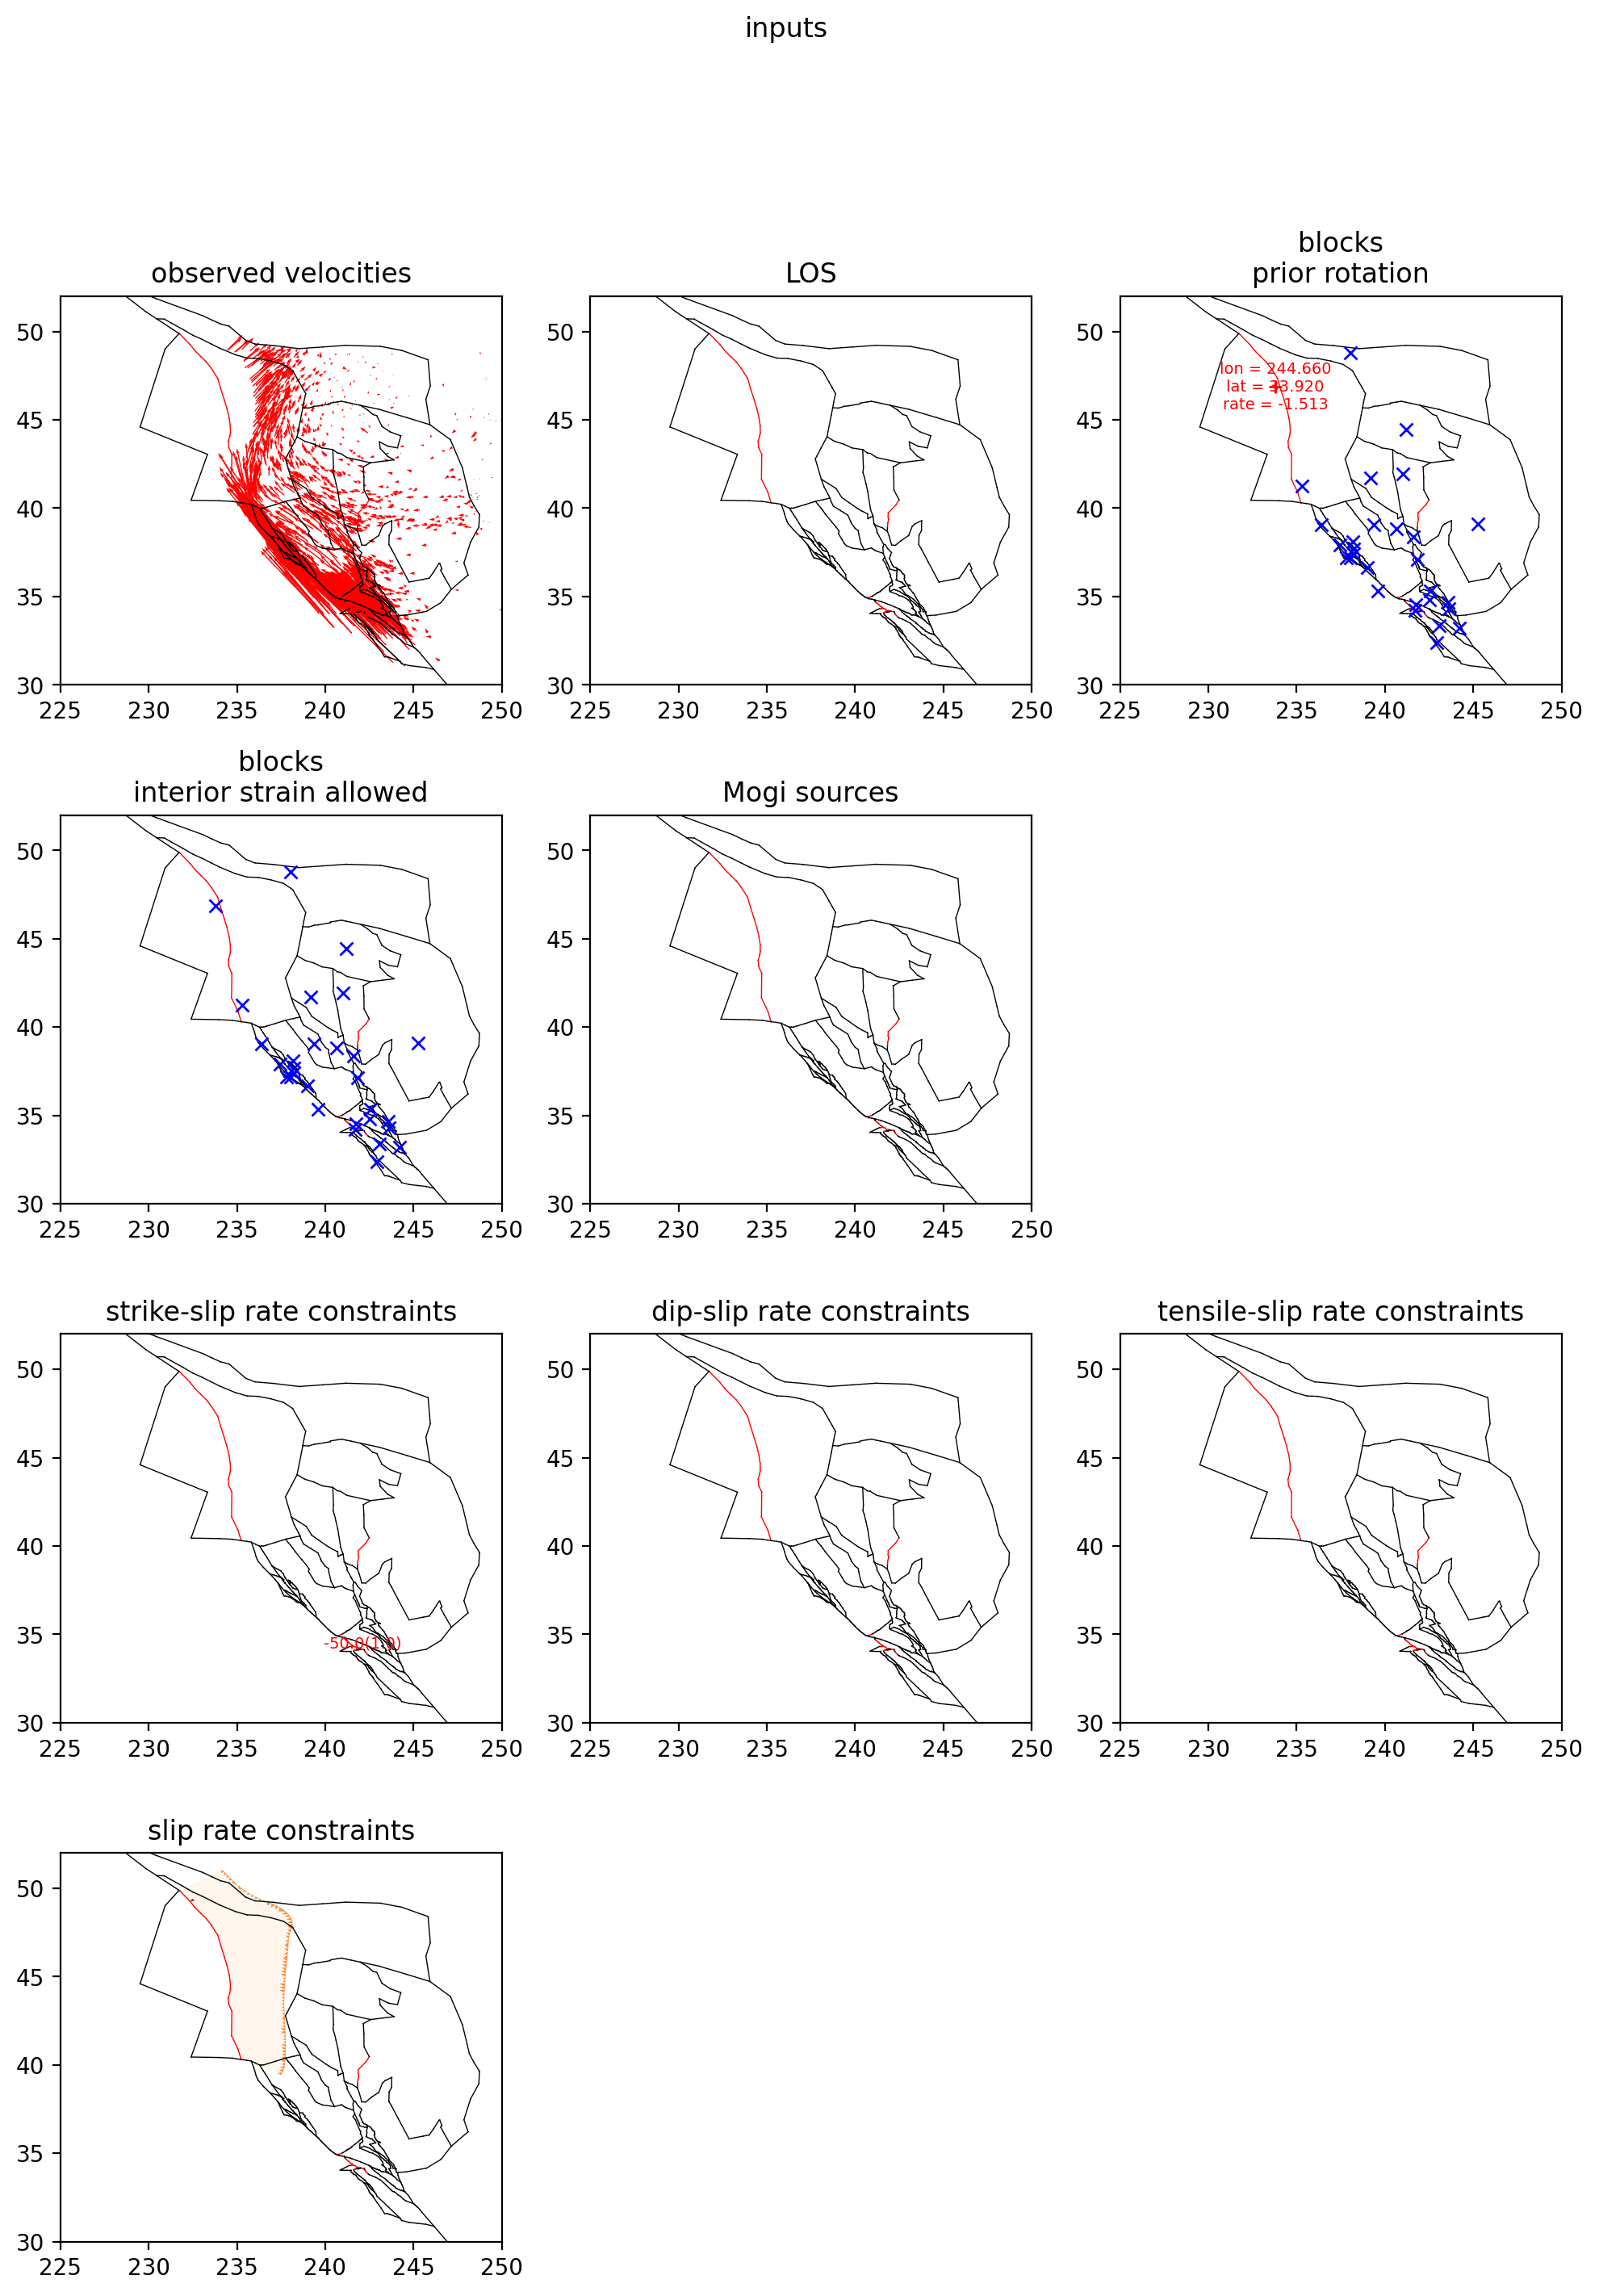

SUCCESS: Wrote figures../runs/0000001066/plot_input_summary.(pdf, png) - celeri.celeri:plot_input_summary:6546 - 2025-05-11 23:20:27


<Figure size 640x480 with 0 Axes>

In [7]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [9]:
index, estimation = celeri.assemble_and_solve_dense(
    command, assembly, operators, station, block, meshes, mogi
)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

ValueError: invalid __array_struct__

# Plot model summary

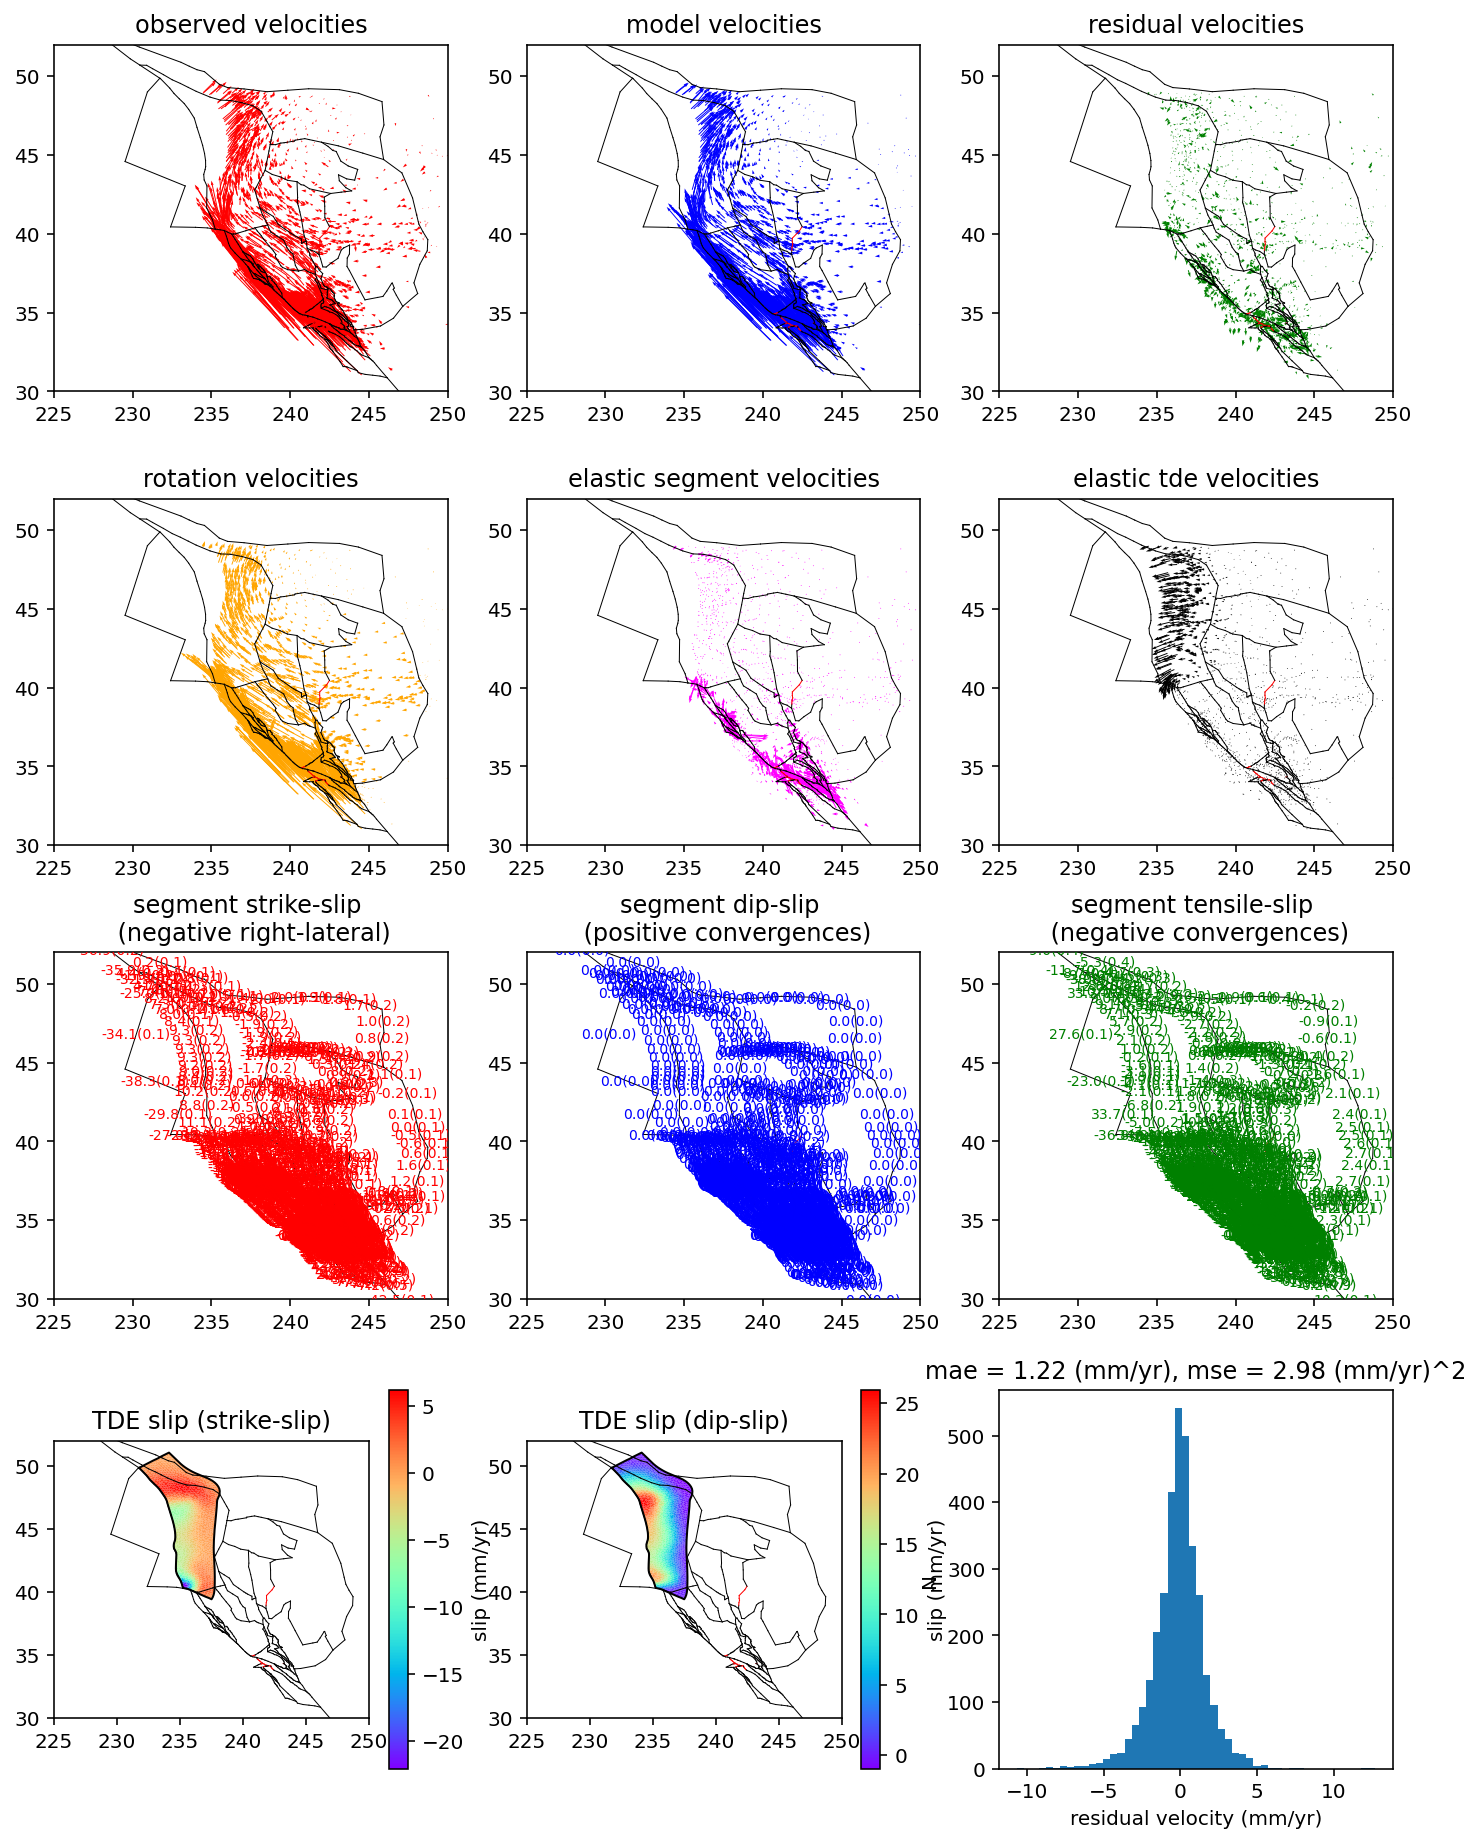

2024-01-01 12:15:24.799 | SUCCESS  | celeri.celeri:plot_estimation_summary:4585 - Wrote figures../runs/2024-01-01-12-15-11/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [ ]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# Experiment: constrainted least squares
- The idea is to constrain TDE slip rates in some region

In [ ]:
lower_bound = np.zeros_like(estimation.state_vector)
upper_bound = np.zeros_like(estimation.state_vector)
lower_bound[:] = -np.inf
upper_bound[:] = np.inf

# Strike-slip
lower_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = -5
upper_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = 5

# Dip-slip
lower_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 0
upper_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 30

In [ ]:
from scipy.optimize import lsq_linear

# Non-linear solver (unbounded)
# res = lsq_linear(
#     estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
#     estimation.data_vector * np.sqrt(estimation.weighting_vector),
#     verbose=1,
# )

# Non-linear solver (bounded [-inf, inf])
res = lsq_linear(
    estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
    estimation.data_vector * np.sqrt(estimation.weighting_vector),
    bounds=(lower_bound, upper_bound),
    verbose=1,
)

import copy

estimation_bounded = copy.deepcopy(estimation)
estimation_bounded.state_vector = res.x
celeri.post_process_estimation(estimation_bounded, operators, station, index)

The algorithm was not able to make progress on the last iteration.
Number of iterations 30, initial cost 2.1970e+04, final cost 1.7086e+04, first-order optimality 5.90e+08.


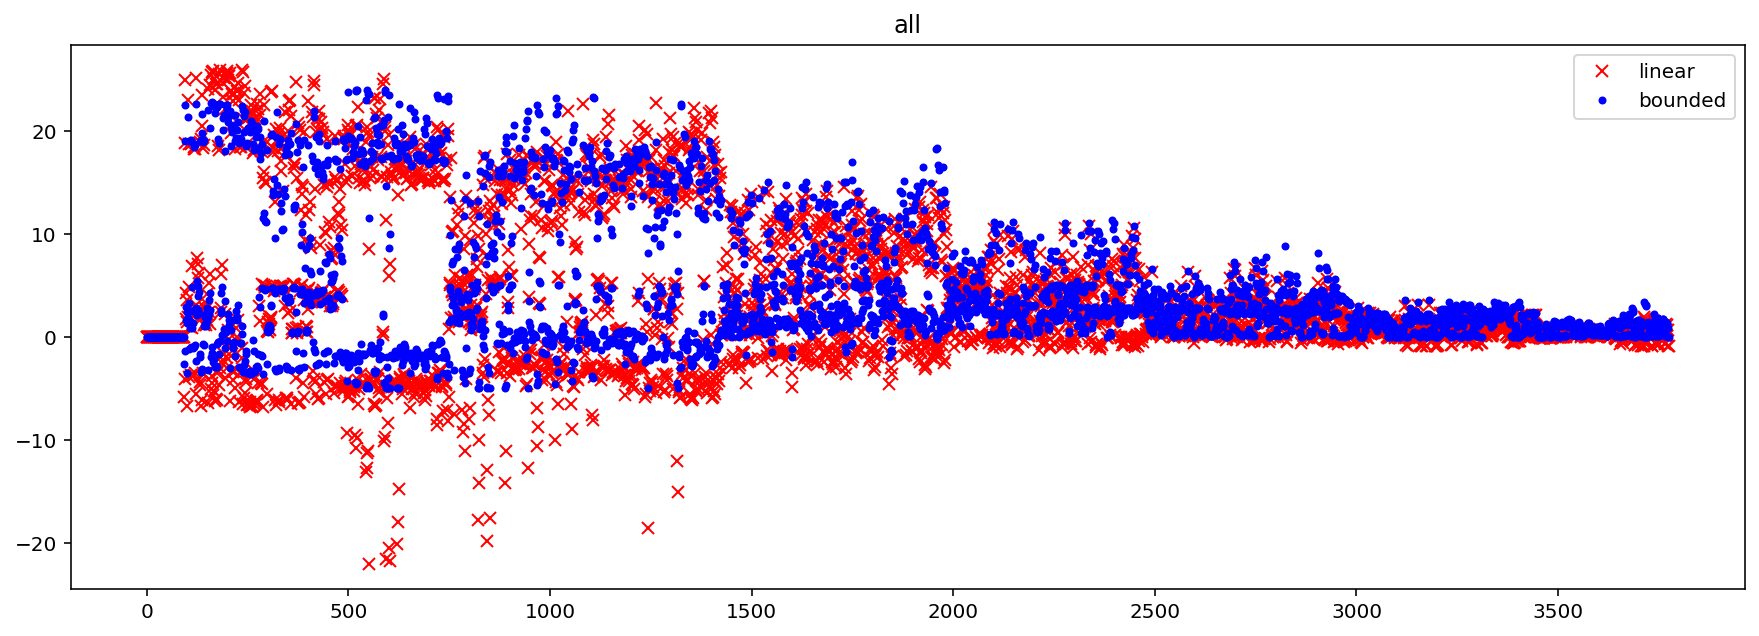

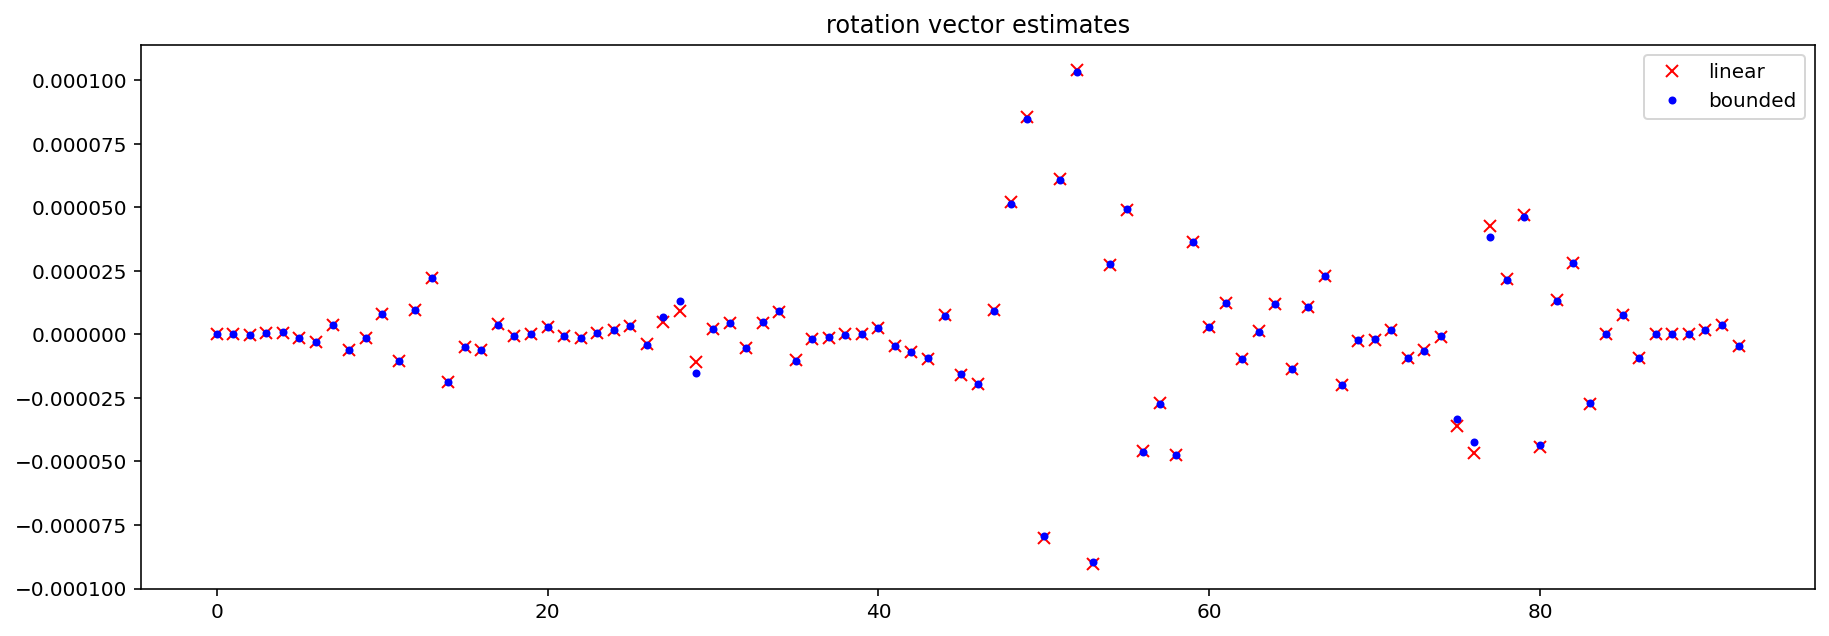

In [ ]:
plt.figure(figsize=(15, 5))
plt.title("all")
plt.plot(estimation.state_vector, "xr", label="linear")
plt.plot(res.x, ".b", label="bounded")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.title("rotation vector estimates")
plt.plot(estimation.state_vector[0 : 3 * index.n_blocks], "xr", label="linear")
plt.plot(res.x[0 : 3 * index.n_blocks], ".b", label="bounded")
plt.legend()
plt.show()

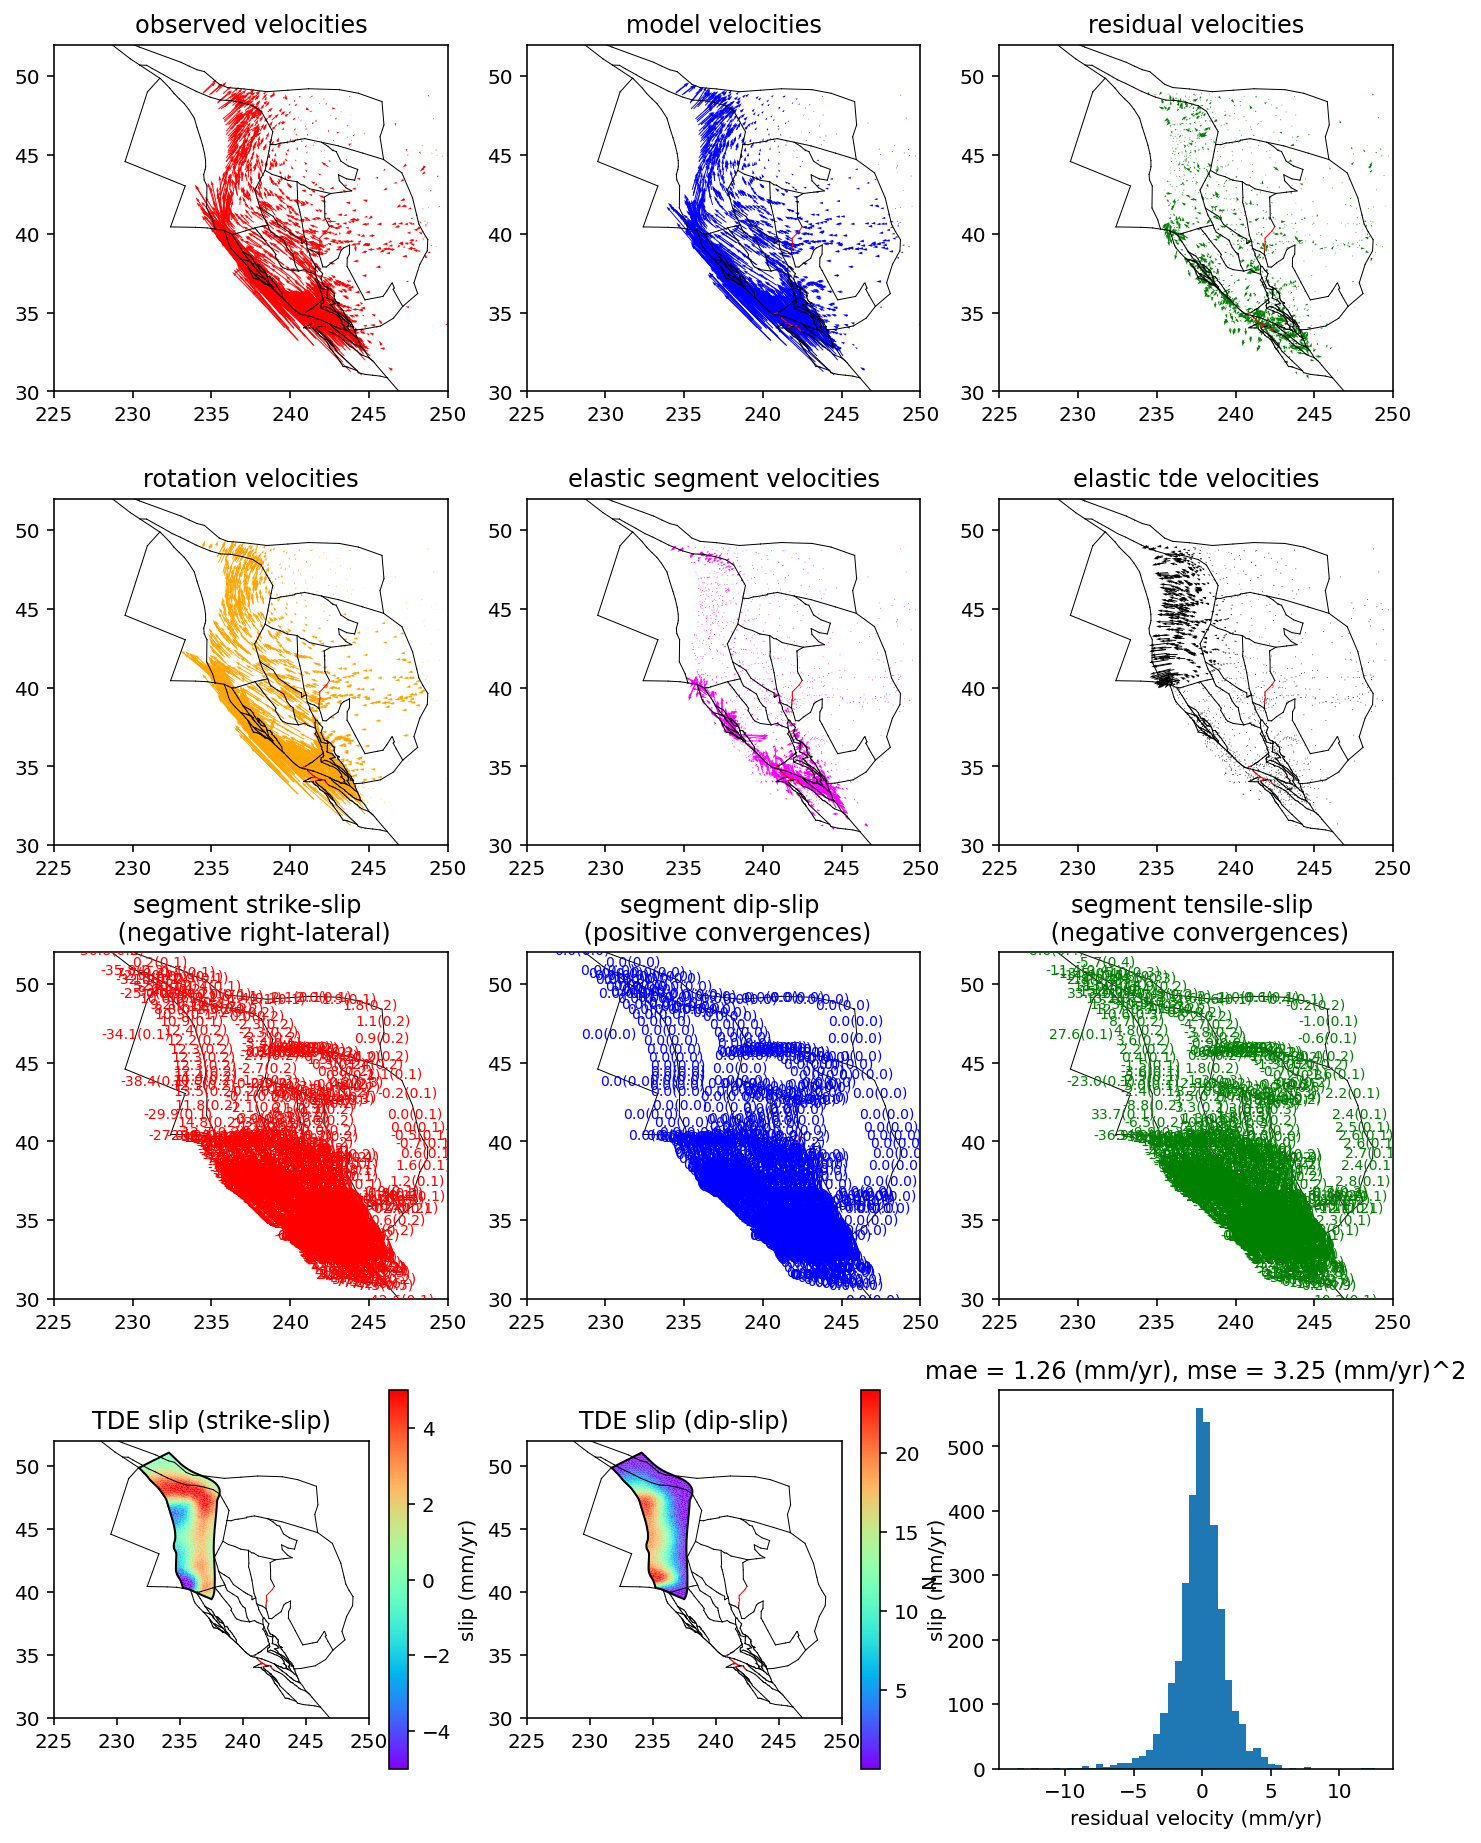

2024-01-01 12:17:48.559 | SUCCESS  | celeri.celeri:plot_estimation_summary:4585 - Wrote figures../runs/2024-01-01-12-15-11/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [ ]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_bounded,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

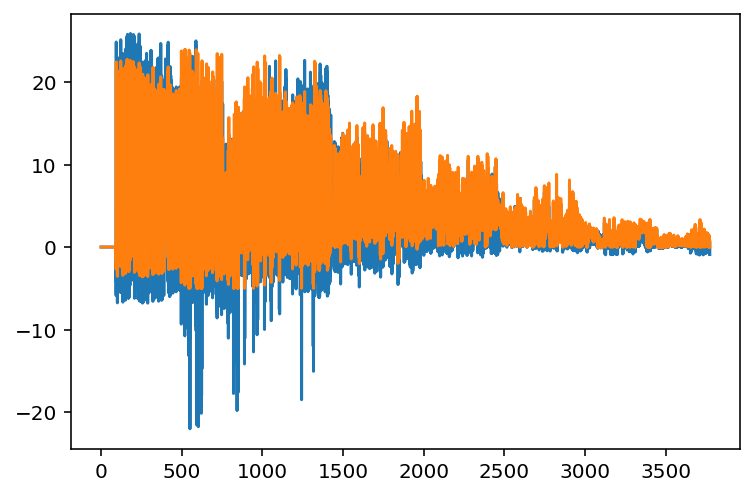

In [ ]:
plt.plot(estimation.state_vector)
plt.plot(estimation_bounded.state_vector)

# `lsq_linear` but with LSMR solve
- Try with Ben's H-matrix preconditioner

In [ ]:
operator_block_only = celeri.get_full_dense_operator_block_only(operators, index)
weighting_vector_block_only = estimation.weighting_vector[
    0 : operator_block_only.shape[0]
][:, None]
col_norms = np.linalg.norm(
    operator_block_only * np.sqrt(weighting_vector_block_only), axis=0
)

In [ ]:
# Non-linear solver (bounded [-inf, inf])
res2 = lsq_linear(
    estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
    estimation.data_vector * np.sqrt(estimation.weighting_vector),
    bounds=(lower_bound, upper_bound),
    lsq_solver="lsmr",
    verbose=1,
)

The relative change of the cost function is less than `tol`.
Number of iterations 98, initial cost 2.2155e+04, final cost 2.2153e+04, first-order optimality 6.72e+02.


In [ ]:
print(col_norms)

[1.32470114e+08 8.96063366e+07 9.28275815e+07 1.20086581e+08
 8.57035937e+07 8.76329750e+07 5.98258802e+07 3.76104812e+07
 4.94786726e+07 1.24399838e+08 1.06414755e+08 1.18911907e+08
 3.43535875e+07 2.11363587e+07 2.46609957e+07 2.65981597e+07
 1.54397861e+07 1.60969627e+07 4.45863908e+06 4.07785204e+06
 3.35854086e+06 9.49664827e+07 6.48813643e+07 7.47144473e+07
 8.11285860e+07 6.72231301e+07 5.86128752e+07 1.53682149e+08
 1.32481270e+08 1.16129002e+08 5.00822805e+07 3.94732757e+07
 3.57999576e+07 5.88115197e+07 4.31704414e+07 4.14394823e+07
 4.42235903e+07 2.93424286e+07 3.03991560e+07 7.92139463e+07
 5.81040548e+07 6.25339541e+07 2.39960833e+07 1.79930163e+07
 1.80458876e+07 5.59158602e+07 3.90273938e+07 4.71224316e+07
 7.29231737e+06 5.93771438e+06 5.36081953e+06 1.39630807e+07
 1.21094973e+07 1.16440058e+07 4.03387983e+07 3.11720427e+07
 3.19179090e+07 6.18086662e+07 4.02963653e+07 5.52839407e+07
 3.68690383e+07 2.02791084e+07 2.85130987e+07 4.51684463e+07
 3.07829406e+07 3.480680

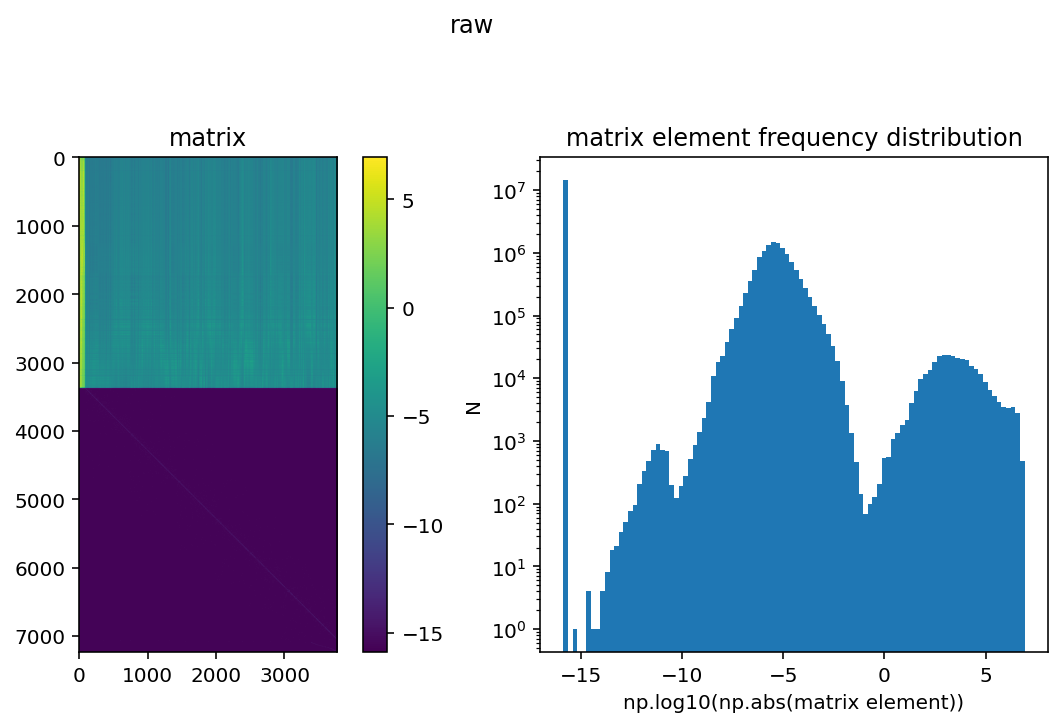

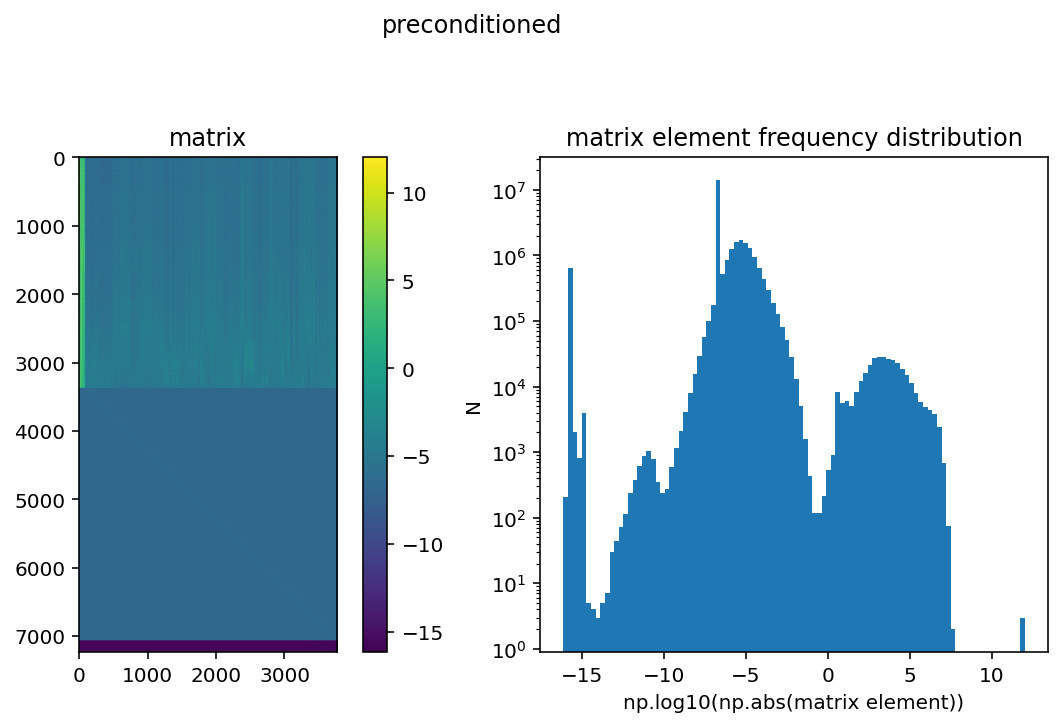

In [ ]:
def matrix_summary_plot(matrix, title_string):
    small_num = np.finfo(float).eps
    matrix[matrix == 0] = small_num
    n_bins = 100
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.title("matrix")
    plt.imshow(np.log10(np.abs(matrix)))
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.title("matrix element frequency distribution")
    plt.hist(np.log10(np.abs(matrix.flatten())), n_bins)
    plt.yscale("log", nonpositive="clip")
    plt.xlabel("np.log10(np.abs(matrix element))")
    plt.ylabel("N")

    plt.suptitle(title_string)
    plt.show()


matrix_summary_plot(estimation.operator, "raw")
matrix_summary_plot(
    estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
    "preconditioned",
)